In [311]:
# import numpy as np
# import pandas as pd
# import matplotlib
# import matplotlib.pyplot as plt

# Generate datetime values
# paas_data = pd.read_csv('./Sample_data_PAAS.csv')
# x = paas_data[paas_data.columns[0]]
# y = paas_data[paas_data.columns[1]]
# paas_data = paas_data.set_index(paas_data.columns[0])
# f = plt.figure()

# f.set_figwidth(240)
# f.set_figheight(100)
# plt.plot(x,y)
# plt.show()
# data = pd.read_csv('./Paas Dataset.csv')
# data["DateTime"] = pd.to_datetime(data["DateTime"])
# data["DateTime"]

In [312]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format
from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [313]:
data = pd.read_csv("./Datasets/IAAS dataset.csv")
data.head()

,DateTime,APU
0,2023-01-01 00:00:00,61.77
1,2023-01-01 03:00:00,62.26
2,2023-01-01 06:00:00,62.35
3,2023-01-01 09:00:00,62.45
4,2023-01-01 12:00:00,62.94


In [314]:
data.columns

Index(['DateTime', 'APU'], dtype='object')

In [315]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248 entries, 0 to 247
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  248 non-null    object 
 1   APU       248 non-null    float64
dtypes: float64(1), object(1)
memory usage: 4.0+ KB


<Axes: >

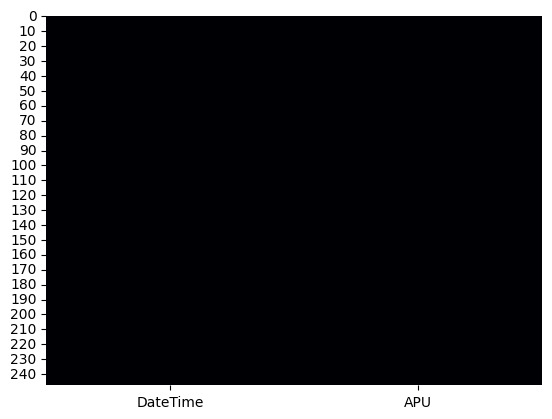

In [316]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False)

In [317]:
data.describe()

,APU
count,248.00
mean,64.29
std,1.95
min,47.74
25%,63.03
50%,64.24
75%,65.45
max,72.71


In [318]:
data = data.set_index('DateTime')

data.head()

,APU
DateTime,
2023-01-01 00:00:00,61.77
2023-01-01 03:00:00,62.26
2023-01-01 06:00:00,62.35
2023-01-01 09:00:00,62.45
2023-01-01 12:00:00,62.94


In [319]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [320]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

<Axes: xlabel='DateTime'>

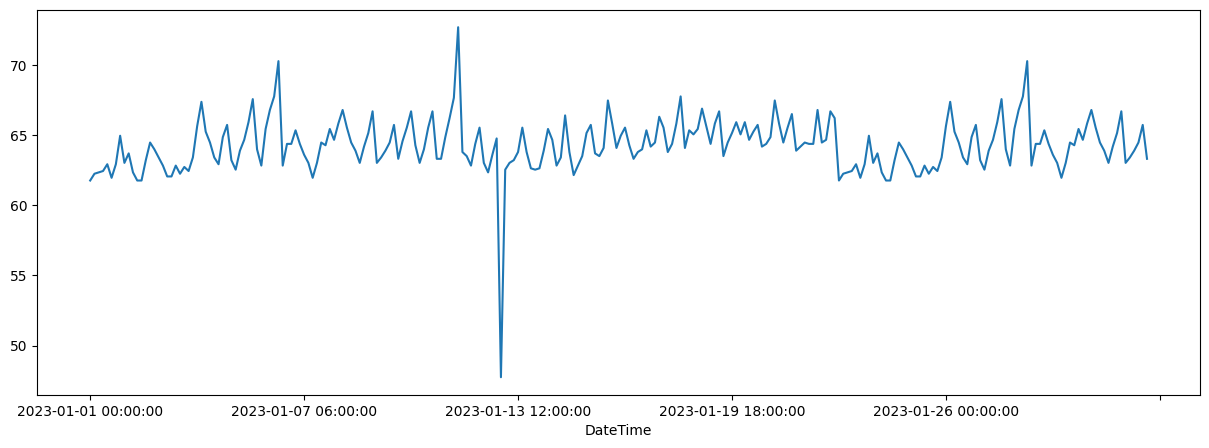

In [321]:
plt.figure(figsize = (15,5))
data[data.columns[0]].plot()

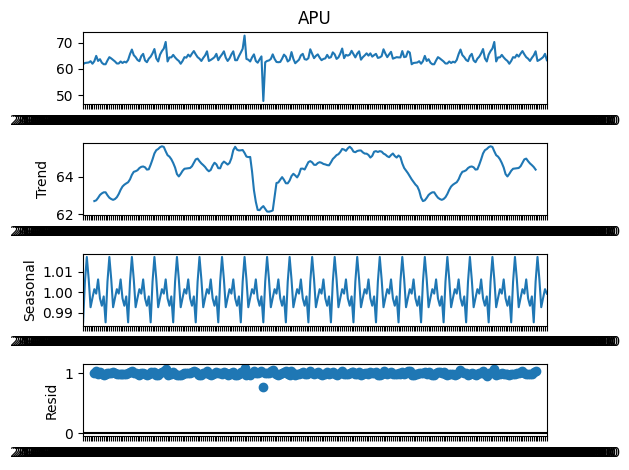

In [322]:
dec = sm.tsa.seasonal_decompose(data[data.columns[0]],period = 12, model = 'multiplicative').plot()
plt.show()

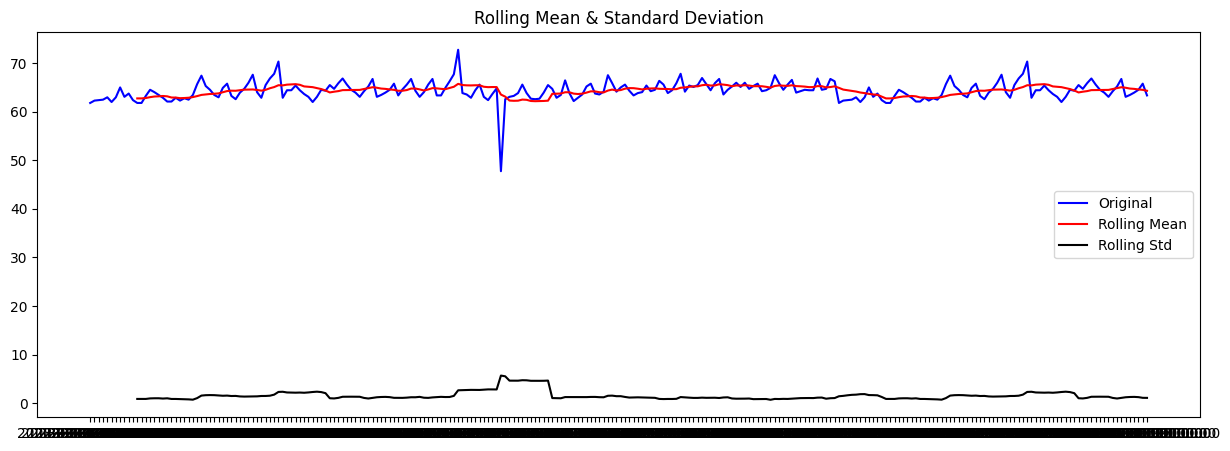

Results of Dickey-Fuller Test:
Test Statistic                -10.85
p-value                         0.00
#Lags Used                      0.00
Number of Observations Used   247.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [323]:
test_stationarity(data[data.columns[0]])

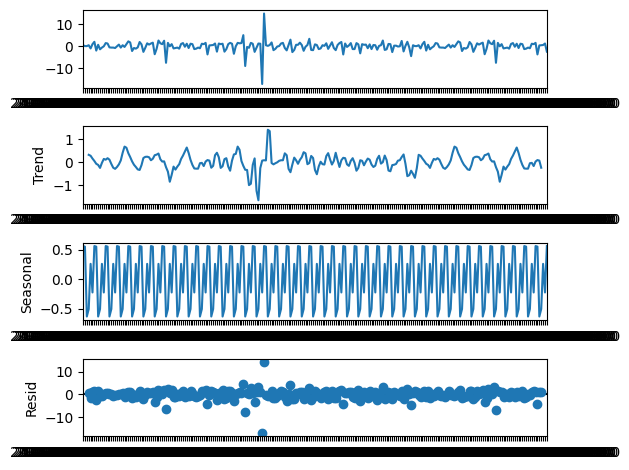

In [324]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 6).plot()
plt.show()

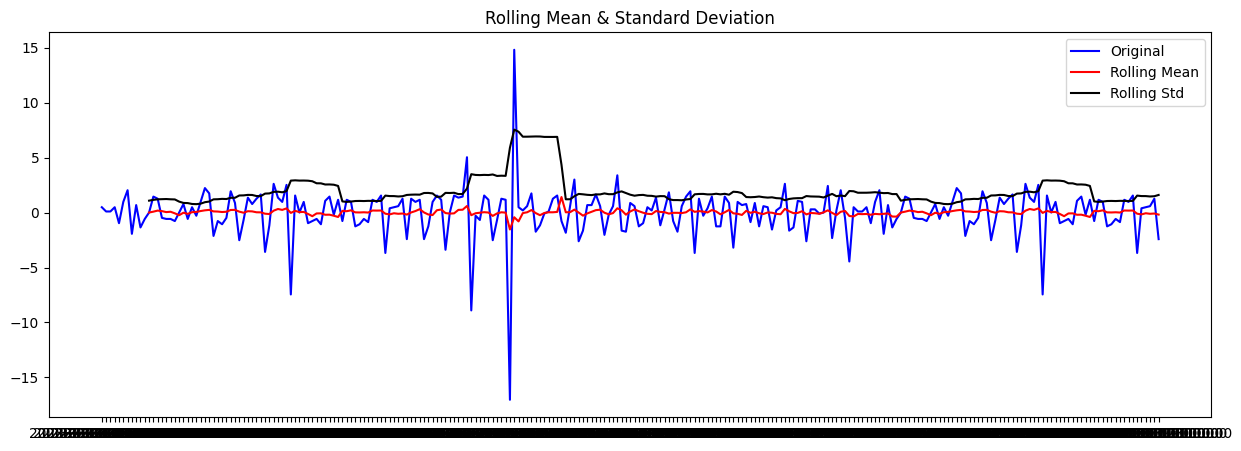

Results of Dickey-Fuller Test:
Test Statistic                 -7.35
p-value                         0.00
#Lags Used                     10.00
Number of Observations Used   236.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [325]:
test_stationarity(data_diff)

/Users/darkshadow/Desktop/Final year project/Code/cloud-optimization/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


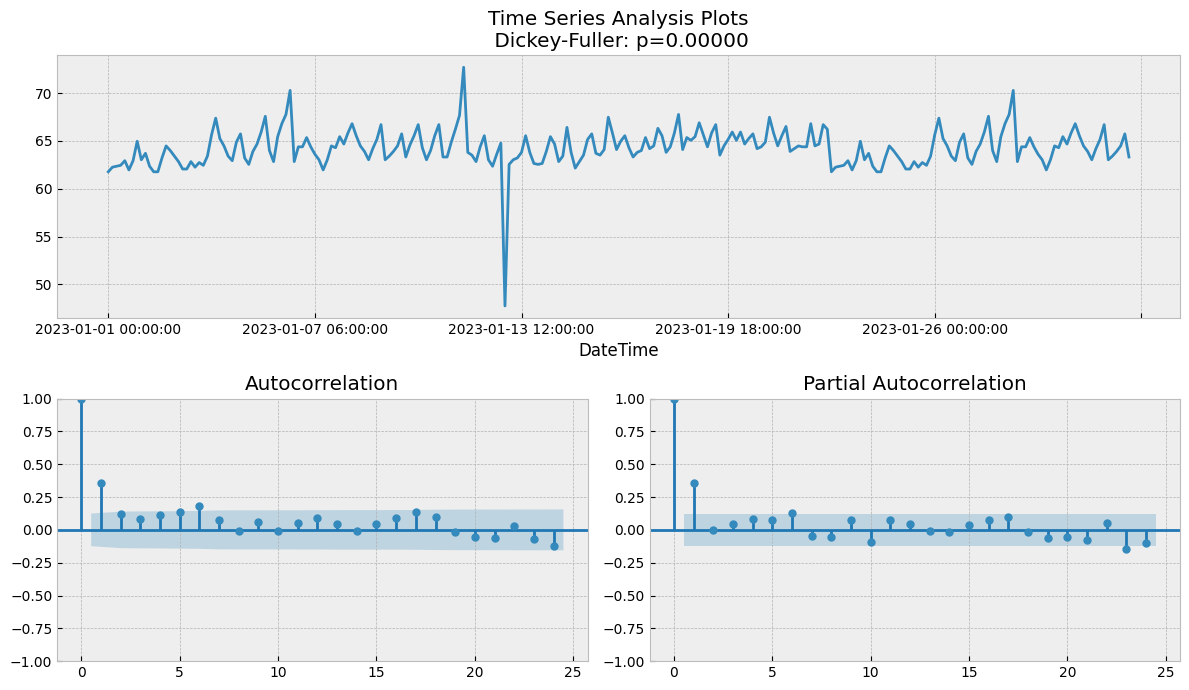

In [326]:
tsplot(data[data.columns[0]])

/Users/darkshadow/Desktop/Final year project/Code/cloud-optimization/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


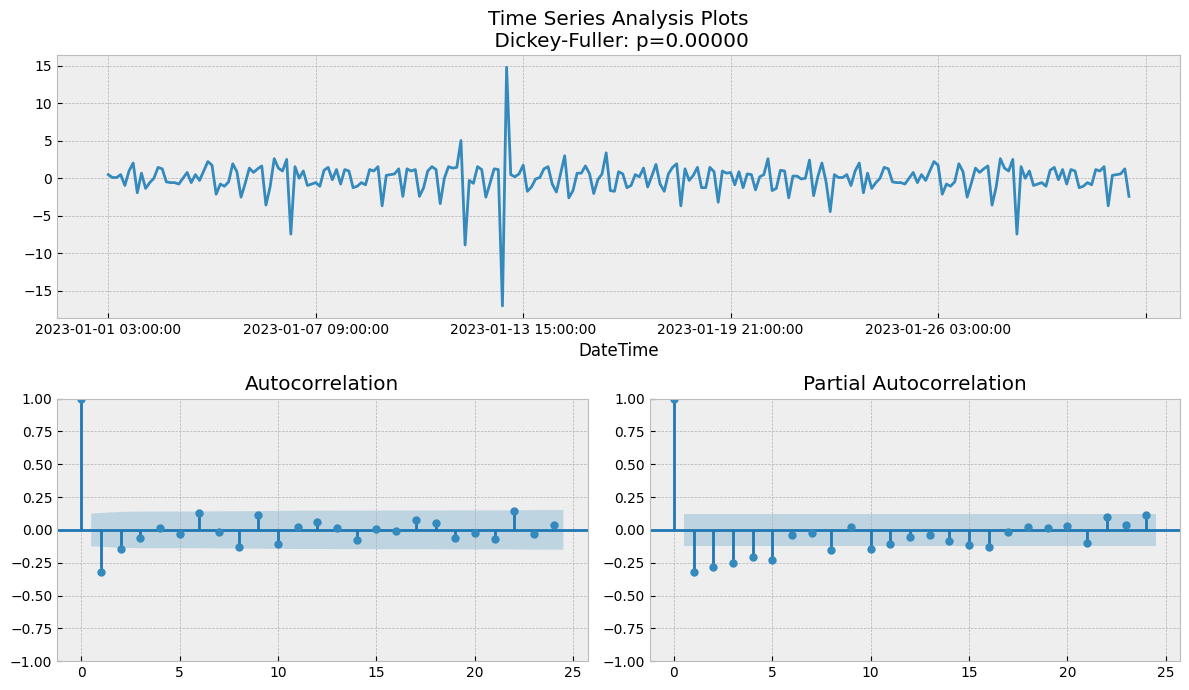

In [327]:
tsplot(data_diff[data.columns[0]])

In [328]:
model = ARIMA(data[data.columns[0]],order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                    APU   No. Observations:                  248
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -500.274
Date:                Sat, 15 Apr 2023   AIC                           1010.547
Time:                        16:55:50   BIC                           1028.094
Sample:                    01-01-2023   HQIC                          1017.612
                         - 01-31-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4202      1.400      0.300      0.764      -2.324       3.164
ar.L2         -0.1079      0.400     -0.270      0.787      -0.892       0.676
ma.L1         -1.0499      1.397     -0.752      0.4

/Users/darkshadow/Desktop/Final year project/Code/cloud-optimization/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/Users/darkshadow/Desktop/Final year project/Code/cloud-optimization/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)
/Users/darkshadow/Desktop/Final year project/Code/cloud-optimization/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 3H will be used.
  self._init_dates(dates, freq)


In [329]:
size = int(len(data) )
train, test = data[data.columns[0]][0:size], data[data.columns[0]][0:size]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(1,2,1))
    model_fit = model.fit()
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 64.104164, expected = 61.774194
predicted = 62.261576, expected = 62.258065
predicted = 62.107392, expected = 62.354839
predicted = 62.326693, expected = 62.451613
predicted = 62.424066, expected = 62.935484
predicted = 62.788480, expected = 61.967742
predicted = 62.273395, expected = 62.935484
predicted = 62.635091, expected = 64.967742
predicted = 64.345301, expected = 63.032258
predicted = 63.650293, expected = 63.709677
predicted = 63.504623, expected = 62.354839
predicted = 62.786559, expected = 61.774194
predicted = 61.956897, expected = 61.774194
predicted = 61.773483, expected = 63.225806
predicted = 62.774033, expected = 64.483871
predicted = 64.102092, expected = 64.000000
predicted = 64.162539, expected = 63.419355
predicted = 63.609007, expected = 62.838710
predicted = 63.025240, expected = 62.064516
predicted = 62.307572, expected = 62.064516
predicted = 62.065279, expected = 62.838710
predicted = 62.601223, expected = 6

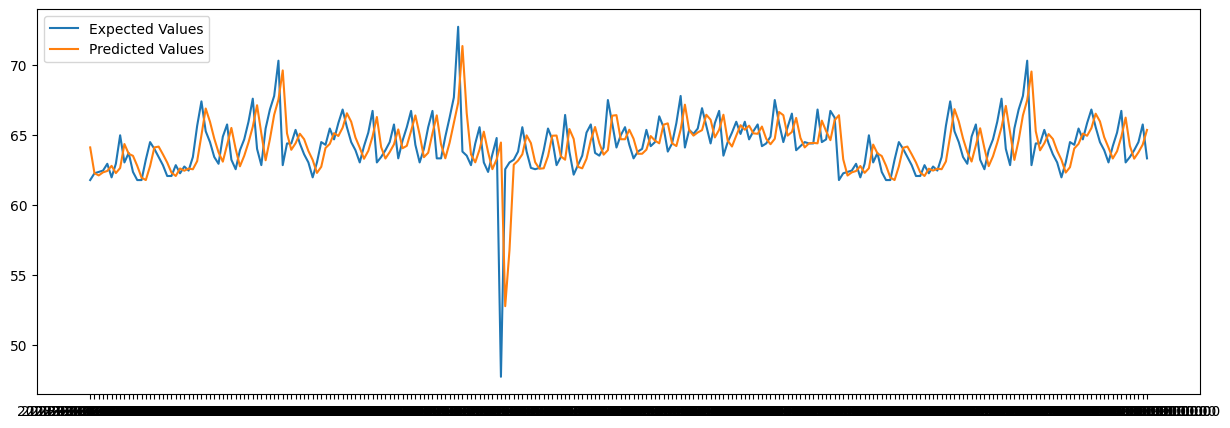

In [330]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data[data.columns[0]],label = 'Expected Values')
plt.plot(predictions_series,label = 'Predicted Values')
plt.legend(loc="upper left")
plt.show()

In [331]:
error = np.sqrt(mean_squared_error(test,predictions))
error1 = np.sqrt(mean_absolute_error(test,predictions))
print('Test RMSE: %.4f' % error)
print('Test MAE: %.4f' % error1)

Test RMSE: 2.1164
Test MAE: 1.1932


In [332]:
from scipy.optimize import differential_evolution

# define the objective function to be minimized
def objective_function(x):
    return (x[0]**2) + (x[1]**2)

# set the bounds of the input variables
bounds = [(-5.0, 5.0), (-5.0, 5.0)]

# use differential evolution to optimize the function
result = differential_evolution(objective_function, bounds)

# print the optimized values
print(result.x)


[0. 0.]


In [334]:
import requests
import json
import numpy as np
from scipy.optimize import differential_evolution

# Define the location
location = 'westus2'



# Define the parameters to optimize
param_bounds = [(1, 32)] * 5  # Allocate 1-32 cores for each instance type

# Define the instance types to consider
instance_types = ['Standard_A4_v2','Standard_A8_v2','Standard_A2m_v2','Standard_DC2s_v2','Standard_DC4s_v2','Standard_D8ps_v5']

# Define the objective function
def instance_objective(params):
    # Calculate the cost of each instance type based on the input parameters
    costs = []
    for i, instance_type in enumerate(instance_types):
        cores = params[i]
        instance_price = get_instance_price(instance_type)
        costs.append(instance_price)
    
    # Return the sum of costs as the objective value
    return sum(costs)

# Define a function to retrieve the price of a given instance type with a given number of cores
def get_instance_price(instance_type):

    
    # Send the API request
    response = requests.get("https://prices.azure.com/api/retail/prices?$filter=serviceFamily eq 'Compute' and armSkuName eq '{instance_type}' ")
    
    # Parse the response
    data = json.loads(response.text)
    try:
        price = data['Items'][0]['retailPrice']
    except KeyError:
        price = None



# Run the optimization
result = differential_evolution(instance_objective, param_bounds)
print('Optimal parameters:', result.x)
print('Optimal cost:', result.fun)


IndexError: list index out of range

In [335]:
import requests

def get_azure_price():
    url = "https://prices.azure.com/api/retail/prices?currencyCode='INR'&$filter=serviceFamily eq 'Compute'"
    response = requests.get(url)
    data = response.json()
    price = data['Items'][0]
    return price
print(get_azure_price())

{'currencyCode': 'INR', 'tierMinimumUnits': 0.0, 'retailPrice': 16.098, 'unitPrice': 16.098, 'armRegionName': 'southindia', 'location': 'IN South', 'effectiveStartDate': '2022-05-01T00:00:00Z', 'meterId': '000009d0-057f-5f2b-b7e9-9e26add324a8', 'meterName': 'D14/DS14 Spot', 'productId': 'DZH318Z0BPVW', 'skuId': 'DZH318Z0BPVW/00QZ', 'availabilityId': None, 'productName': 'Virtual Machines D Series Windows', 'skuName': 'D14 Spot', 'serviceName': 'Virtual Machines', 'serviceId': 'DZH313Z7MMC8', 'serviceFamily': 'Compute', 'unitOfMeasure': '1 Hour', 'type': 'DevTestConsumption', 'isPrimaryMeterRegion': True, 'armSkuName': 'Standard_D14'}


In [ ]:
#!/usr/bin/env python3
import requests
import json,time
from tabulate import tabulate 


def build_pricing_table(json_data, table_data):
    for item in json_data['Items']:
        meter = item['meterName']
        table_data.append([item['armSkuName'], item['retailPrice'], item['unitOfMeasure'], item['armRegionName'], meter, item['productName']])
        
def main():
    table_data = []
    table_data.append(['SKU', 'Retail Price', 'Unit of Measure', 'Region', 'Meter', 'Product Name'])
    
    api_url = "https://prices.azure.com/api/retail/prices?api-version=2021-10-01-preview"
    query = "serviceName eq 'Virtual Machines' and serviceFamily eq 'Compute' "
    response = requests.get(api_url, params={'$filter': query})
    json_data = json.loads(response.text)
    
    build_pricing_table(json_data, table_data)
    nextPage = json_data['NextPageLink']
    start_time = time.time()
    while(nextPage):
        current_time = time.time()
        elapsed_time = current_time - start_time
        if elapsed_time > 60:
            break
        response = requests.get(nextPage)
        json_data = json.loads(response.text)
        nextPage = json_data['NextPageLink']
        build_pricing_table(json_data, table_data)
        
    print(tabulate(table_data, headers='firstrow', tablefmt='psql'))
    
if __name__ == "__main__":
    main()

+--------------------------+----------------+-------------------+--------------------+-------------------------------+---------------------------------------------+
| SKU                      |   Retail Price | Unit of Measure   | Region             | Meter                         | Product Name                                |
|--------------------------+----------------+-------------------+--------------------+-------------------------------+---------------------------------------------|
| Standard_D14             |       0.1955   | 1 Hour            | southindia         | D14/DS14 Spot                 | Virtual Machines D Series Windows           |
| Standard_D14             |       0.32292  | 1 Hour            | southindia         | D14/DS14 Spot                 | Virtual Machines D Series Windows           |
| Standard_D64s_v5         |       0.940013 | 1 Hour            | eastasia           | D64s v5 Spot                  | Virtual Machines Dsv5 Series Windows        |
| Standard